<a href="https://colab.research.google.com/github/aotal/ImagenMedica/blob/master/Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import random
import torchvision.models as models

Definimos vectores

In [ ]:
vector_1 = np.array([1, 2, 3])
vector_2 = np.array([4, 5, 6])
vector_3 = np.array([2, -1, 0])
vector_4 = np.array([2, 4, 6])


Calculamos la similitud del coseno de dos vectores

![Similitud de dos vectores](https://www.mathsisfun.com/algebra/images/dot-product-ex2.gif)

In [ ]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [ ]:
similarity_1_2 = cosine_similarity(vector_1, vector_2)
similarity_1_3 = cosine_similarity(vector_1, vector_3)
similarity_2_3 = cosine_similarity(vector_2, vector_3)
similarity_1_4 = cosine_similarity(vector_1, vector_4)

Mostramos los resultados

In [ ]:
print("Similitud de coseno entre vector_1 y vector_2:", similarity_1_2)
print("Similitud de coseno entre vector_1 y vector_3:", similarity_1_3)
print("Similitud de coseno entre vector_2 y vector_3:", similarity_2_3)
print("Similitud de coseno entre vector_1 y vector_4:", similarity_1_4)

Similitud de coseno entre vector_1 y vector_2: 0.9746318461970762
Similitud de coseno entre vector_1 y vector_3: 0.0
Similitud de coseno entre vector_2 y vector_3: 0.15289415743128765
Similitud de coseno entre vector_1 y vector_4: 1.0


Vamos ahora a por un modelo de texto.Cargamos el modelo

In [ ]:
model_name_bert = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name_bert)
model = BertModel.from_pretrained(model_name_bert)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def cosine_similarity(v1, v2):
    return 1 - cosine(v1, v2)

In [ ]:
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

In [ ]:
def calculate_text_similarity(text1, text2):
    """
    Función para calcular la similitud de coseno entre dos textos basada en sus representaciones vectoriales BERT.

    Args:
        text1 (str): Primer texto.
        text2 (str): Segundo texto.

    Returns:
        float: Similitud de coseno entre las representaciones vectoriales de los dos textos.
    """
    # Obtener las representaciones vectoriales BERT para ambos textos
    embeddings_text1 = get_bert_embeddings(text1)
    embeddings_text2 = get_bert_embeddings(text2)

    # Calcular la similitud de coseno entre las representaciones vectoriales
    similarity = cosine_similarity(embeddings_text1, embeddings_text2)
    return similarity


In [ ]:
# Ejemplo de uso:
text1 = "orange is a color"
text2 = "orange is a fruit"
similarity = calculate_text_similarity(text1, text2)
print("Similarity:", similarity)

Similarity: 0.8144723176956177


Probemos ahora con un modelo de imágenes

Primero bajamos las imágenes de nuestra querida base de datos MNIST

In [ ]:
# Transformación para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Descargar la base de datos MNIST y aplicar transformaciones
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Crear cargadores de datos para acceder a los datos por lotes
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)




100%|██████████| 9912422/9912422 [00:00<00:00, 175017306.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26847449.87it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43325866.23it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4608255.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def get_random_images(number1, number2, dataset=test_dataset, seed=42):
    """
    Función para obtener dos imágenes al azar de un conjunto de datos para dos números específicos.

    Args:
        dataset: Conjunto de datos del que se seleccionarán las imágenes.
        number1: Primer número para seleccionar imágenes.
        number2: Segundo número para seleccionar imágenes.
        seed: Semilla para reproducibilidad. Por defecto, 42.

    Returns:
        tuple: Tupla de dos imágenes y etiquetas seleccionadas al azar.
    """
    # Obtener los índices de las imágenes para cada número
    indices1 = [i for i, (image, label) in enumerate(dataset) if label == number1]
    indices2 = [i for i, (image, label) in enumerate(dataset) if label == number2]

    # Seleccionar dos índices al azar para cada número
    random.seed(seed)
    rand_idx1 = random.randint(0, len(indices1) - 1)
    rand_idx2 = random.randint(0, len(indices2) - 1)

    # Obtener los datos de las imágenes seleccionadas
    image1, label1 = dataset[indices1[rand_idx1]]
    image2, label2 = dataset[indices2[rand_idx2]]

    return (image1, label1), (image2, label2)

def show_images(image_label1, image_label2):
    """
    Función para mostrar dos imágenes junto con sus etiquetas en la misma ventana.

    Args:
        image_label1: Tupla que contiene la primera imagen y su etiqueta.
        image_label2: Tupla que contiene la segunda imagen y su etiqueta.
    """
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image_label1[0].squeeze(), cmap='gray')
    plt.title('Label: {}'.format(image_label1[1]))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_label2[0].squeeze(), cmap='gray')
    plt.title('Label: {}'.format(image_label2[1]))
    plt.axis('off')

    plt.show()

In [ ]:
tupla1,tupla2=get_random_images(1,5)

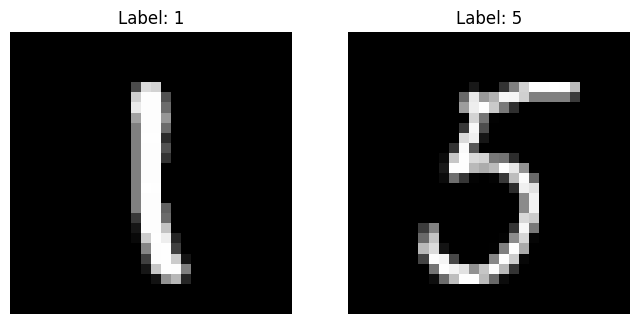

In [ ]:
show_images(tupla1,tupla2)

Cargamos un modelo genérico, en nuestro caso ResNet

In [ ]:
# Cargar el modelo pre-entrenado
model_resnet = models.resnet18(pretrained=True)
# Eliminar la capa de clasificación
model_resnet = torch.nn.Sequential(*(list(model_resnet.children())[:-1]))
model_resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
def calculate_image_similarity(image_label1, image_label2, model=model_resnet):
    """
    Función para calcular la similitud de coseno entre dos imágenes basadas en sus representaciones vectoriales.

    Args:
        image_label1: Tupla que contiene la primera imagen y su etiqueta.
        image_label2: Tupla que contiene la segunda imagen y su etiqueta.
        model: Modelo utilizado para obtener las representaciones vectoriales de las imágenes.

    Returns:
        float: Similitud de coseno entre las representaciones vectoriales de las dos imágenes.
    """
    def get_image_embeddings(image_tensor):
        with torch.no_grad():
            # Expande la dimensión de los canales para que coincida con lo que el modelo espera (de 1 a 3 canales)
            image_tensor = image_tensor.repeat(1, 3, 1, 1)
            # Pasar la imagen a través del modelo y obtener la representación vectorial
            output = model(image_tensor)
            # Aplanar la salida
            output = output.view(output.size(0), -1)
            # Normalizar la salida
            output = F.normalize(output, p=2, dim=1)
        return output

    # Obtener los tensores de imagen de las tuplas
    image_tensor1, _ = image_label1
    image_tensor2, _ = image_label2

    # Obtener las representaciones vectoriales de las imágenes
    image1_embedding = get_image_embeddings(image_tensor1.unsqueeze(0))
    image2_embedding = get_image_embeddings(image_tensor2.unsqueeze(0))

    # Calcular la similitud de coseno entre las representaciones vectoriales
    similarity = F.cosine_similarity(image1_embedding, image2_embedding)
    return similarity.item()

In [ ]:
calculate_image_similarity(tupla1,tupla2)

0.6484431028366089

Cargamos ahora un modelo *finetuneado* para el conjunto MNIST

In [ ]:
def preprocess_input(input_tensor, target_size=(224, 224)):
    """
    Función para preprocesar un tensor de entrada para que coincida con el tamaño y formato esperado por el modelo.

    Args:
        input_tensor (torch.Tensor): Tensor de entrada con un solo canal.
        target_size (tuple): Tamaño al que se debe redimensionar la imagen. Por defecto, (224, 224).

    Returns:
        torch.Tensor: Tensor de entrada preprocesado con el tamaño y formato correctos.
    """
    # Definir una transformación para redimensionar la imagen
    resize_transform = transforms.Compose([
        transforms.Resize(target_size),  # Redimensionar la imagen al tamaño objetivo
    ])

    # Redimensionar el tensor de entrada
    input_tensor_resized = resize_transform(input_tensor)

    # Replicar el canal único en tres canales
    input_tensor_rgb = input_tensor_resized.expand(1, 3, *target_size)  # Expandir el tensor a tres canales

    return input_tensor_rgb


def preprocess_and_infer(tupla1, tupla2, model=model_mnist2):
    """
    Función para preprocesar dos imágenes de entrada y realizar inferencia con un modelo dado.

    Args:
        tupla1: Tupla que contiene la primera imagen y su etiqueta.
        tupla2: Tupla que contiene la segunda imagen y su etiqueta.
        model: Modelo utilizado para la inferencia.

    Returns:
        torch.Tensor: Salida del modelo para la primera imagen.
        torch.Tensor: Salida del modelo para la segunda imagen.
    """
    # Añadir un nuevo eje de canal a las imágenes y realizar la inferencia con el modelo
    with torch.no_grad():
        image1_tensor = preprocess_input(tupla1[0])
        image2_tensor = preprocess_input(tupla2[0])
        outputs1 = model(image1_tensor)
        outputs2 = model(image2_tensor)

    return F.cosine_similarity(outputs1.to_tuple()[0], outputs2.to_tuple()[0], dim=1)

# Ejemplo de uso:
# outputs1, outputs2 = preprocess_and_infer(tupla1, tupla2, model_mnist2)


In [ ]:
preprocess_and_infer(tupla1, tupla2)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([-0.1767])